In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *
from src.samplers import *
from src.metrics import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch module path: /home/jonasm/.venv/lib/python3.10/site-packages/torch/__init__.py
torch module dir: ['AVG', 'AcceleratorError', 'AggregationType', 'AliasDb', 'AnyType', 'Argument', 'ArgumentSpec', 'AwaitType', 'BFloat16Storage', 'BFloat16Tensor', 'BenchmarkConfig', 'BenchmarkExecutionStats', 'Block', 'BoolStorage', 'BoolTensor', 'BoolType', 'BufferDict', 'ByteStorage', 'ByteTensor', 'CallStack', 'Capsule', 'CharStorage', 'CharTensor', 'ClassType', 'Code', 'CompilationUnit', 'CompleteArgumentSpec', 'ComplexDoubleStorage', 'ComplexFloatStorage', 'ComplexType', 'ConcreteModuleType', 'ConcreteModuleTypeBuilder', 'DeepCopyMemoTable', 'DeserializationStorageContext', 'DeviceObjType', 'DictType', 'DisableTorchFunction', 'DisableTorchFunctionSubclass', 'DispatchKey', 'DispatchKeySet', 'DoubleStorage', 'DoubleTensor', 'EnumType', 'ErrorReport', 'Event', 'ExcludeDispatchKeyGuard', 'ExecutionPlan', 'FatalError', 'FileCheck', 'FloatStorage', 'FloatTensor', 'FloatType', 'FunctionSchema', 'Future

In [2]:
GaussianMix = GaussianMixture.symmetric_2D(4,1.0)

gaussian_path = GaussianConditionalProbabilityPath(p_data=GaussianMix, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = BasicMLP(input_dim=2, output_dim=1, hidden_dims=[64,64,64,64])

trainer = FlowDiffTrainer(path=gaussian_path, modeltype="density", model=model1)

trainer.train_loop(num_epochs=20000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 11.90760612487793
In Epoch 1000 we have a loss of 5.786633014678955
In Epoch 2000 we have a loss of 7.98545503616333
In Epoch 3000 we have a loss of 27.245454788208008
In Epoch 4000 we have a loss of 6.623416900634766
In Epoch 5000 we have a loss of 10.733829498291016
In Epoch 6000 we have a loss of 5.665502071380615
In Epoch 7000 we have a loss of 5.208619594573975
In Epoch 8000 we have a loss of 19.983278274536133
In Epoch 9000 we have a loss of 13.812252044677734
In Epoch 10000 we have a loss of 9.444698333740234
In Epoch 11000 we have a loss of 6.692018985748291
In Epoch 12000 we have a loss of 5.269064903259277
In Epoch 13000 we have a loss of 6.610167503356934
In Epoch 14000 we have a loss of 8.736868858337402
In Epoch 15000 we have a loss of 5.013058185577393
In Epoch 16000 we have a loss of 11.529619216918945
In Epoch 17000 we have a loss of 4.410083293914795
In Epoch 18000 we have a loss of 7.502464771270752
In Epoch 19000 we have a loss of 6.07836

In [3]:
rec1 = Rectangle(device=device, coords= [(-5.0,5.0),(-10,10)])

gaussian_path2 = GaussianConditionalProbabilityPath(p_data=rec1, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model2 = BasicMLP(input_dim=2, output_dim= 1, hidden_dims=[64,64,64,64])

trainer2 = FlowDiffTrainer(path=gaussian_path2, modeltype="density", model=model2)

trainer2.train_loop(num_epochs=20000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 7.91295862197876
In Epoch 1000 we have a loss of 15.317962646484375
In Epoch 2000 we have a loss of 6.854510307312012
In Epoch 3000 we have a loss of 29.348039627075195
In Epoch 4000 we have a loss of 8.565317153930664
In Epoch 5000 we have a loss of 11.676554679870605
In Epoch 6000 we have a loss of 5.655730724334717
In Epoch 7000 we have a loss of 12.65704345703125
In Epoch 8000 we have a loss of 5.928125381469727
In Epoch 9000 we have a loss of 5.621573448181152
In Epoch 10000 we have a loss of 9.734908103942871
In Epoch 11000 we have a loss of 6.097822666168213
In Epoch 12000 we have a loss of 19.801231384277344
In Epoch 13000 we have a loss of 7.411276340484619
In Epoch 14000 we have a loss of 8.80452823638916
In Epoch 15000 we have a loss of 9.113628387451172
In Epoch 16000 we have a loss of 6.9075493812561035
In Epoch 17000 we have a loss of 6.047863483428955
In Epoch 18000 we have a loss of 7.197110176086426
In Epoch 19000 we have a loss of 8.704856

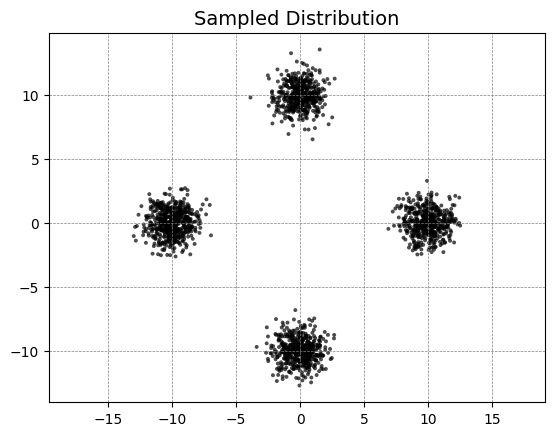

In [4]:
plot_samples(GaussianMix.sample(2000))
plt.show()

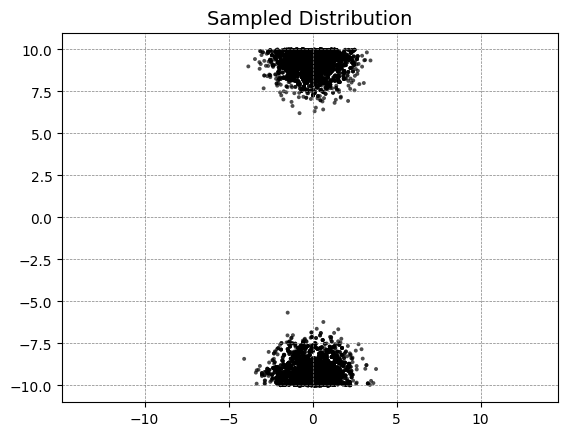

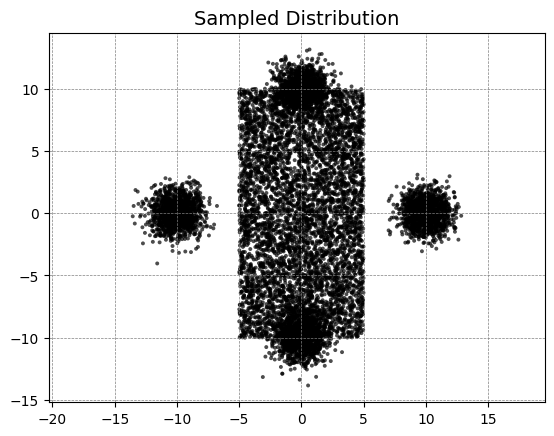

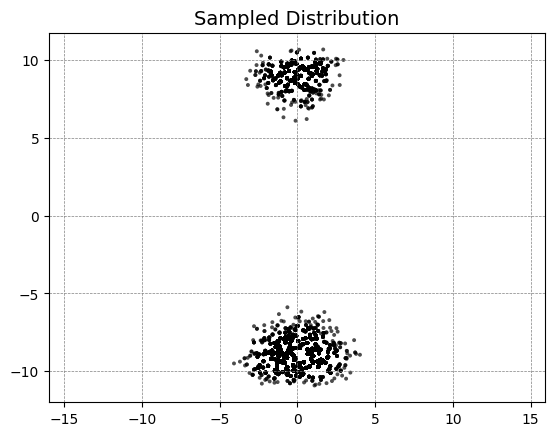

In [20]:
#samples = sample_UnionLangevin(models = [model1,model2], n= 2000, path = gaussian_path, device="cuda")
#plot_samples(samples, contour=False, scatter=True)

#sample = DensityCompSample(models = [model1,model2], n= 2000, path = gaussian_path, proposal_density = model1, n_importance=2000, device="cuda")
prod = ProductLogSample(densities=[GaussianMix, rec1], proposal_density=UnionLogSample(densities=[GaussianMix, rec1]))
union = UnionLogSample(densities=[GaussianMix, rec1])

plot_samples(prod.sample(11000))
plt.show()
plot_samples(union.sample(11000))
plt.show()
rec2 = Rectangle(device=device, coords= [(-15.0,15.0),(-15,15)])

sam, Z, w, ess = DensityCompSampleNormalized(models = [model1,model2], proposal=rec2, n= 11000, path = gaussian_path, n_importance = 11000, device="cuda", true_density=True, t_final=0.99)
plot_samples(sam, contour=False, scatter=True)
#plot_samples(sample_CompLangevin(models = [model1,model2], n= 2000, path = gaussian_path, device="cuda"))

=== SPARSITY ANALYSIS ===
Testing different configurations to reduce sparsity...


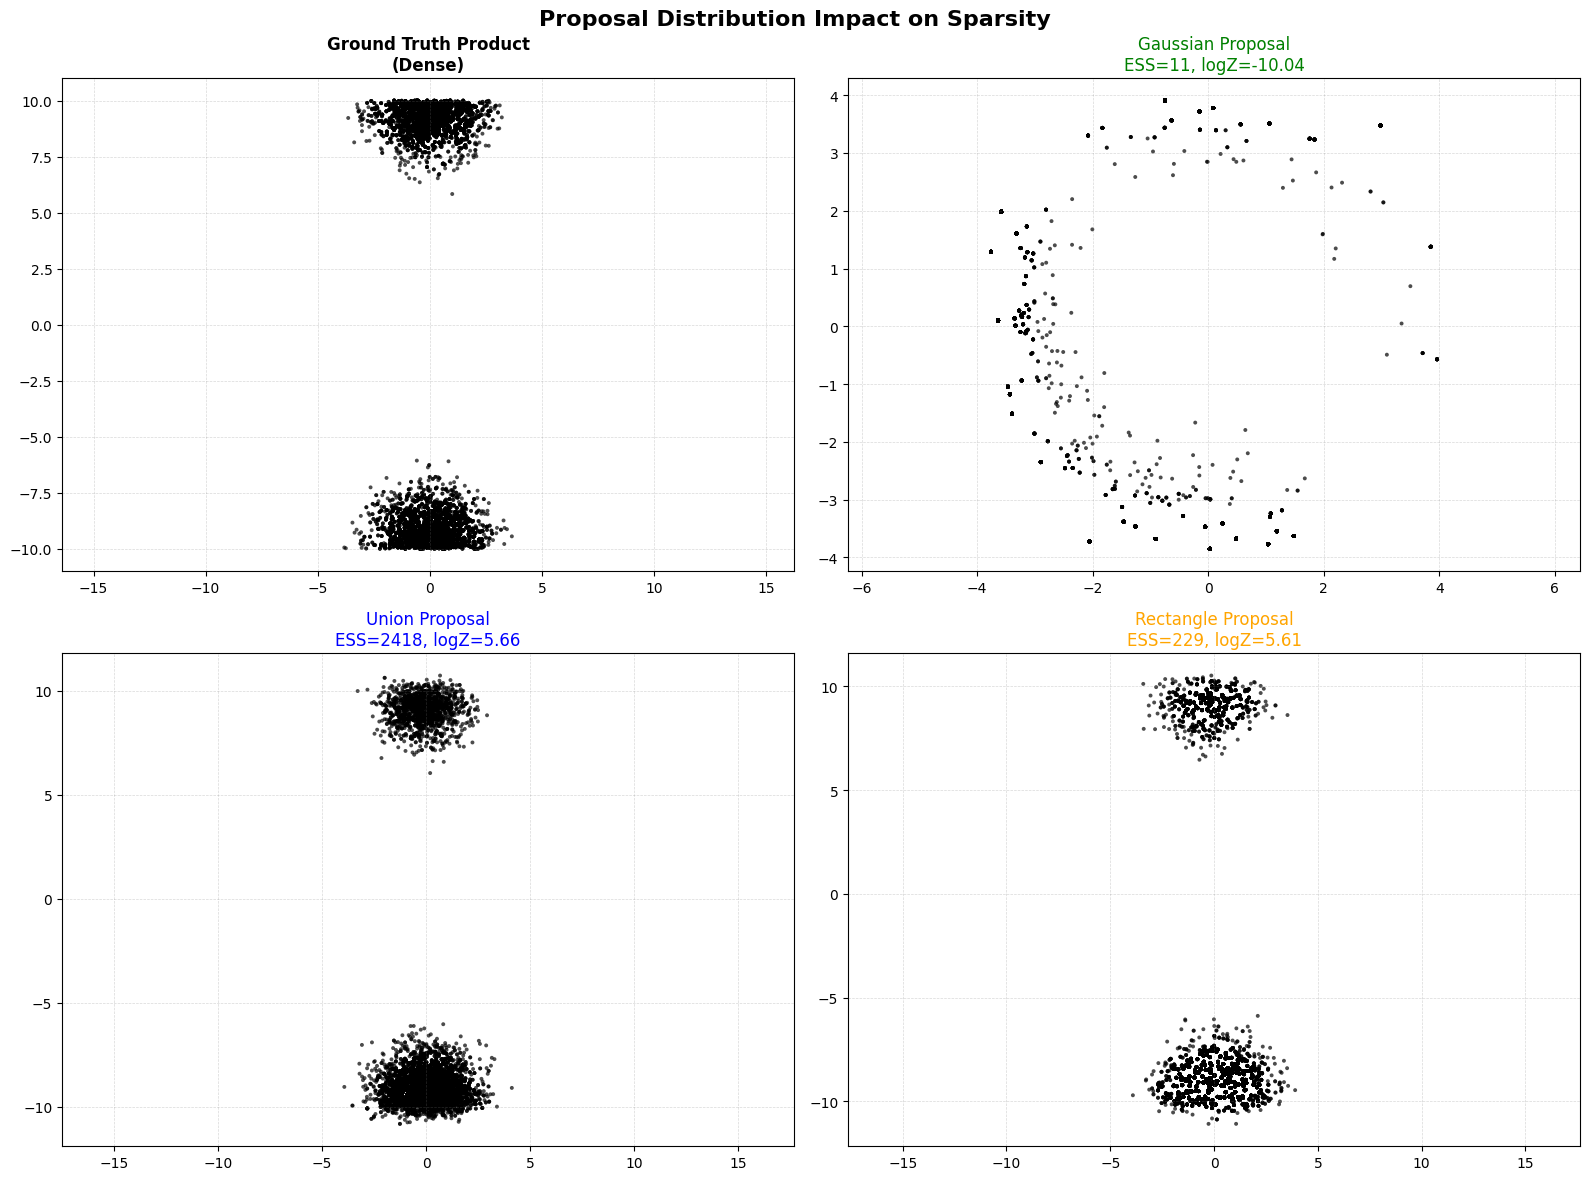


DIAGNOSTICS:
Gaussian proposal - ESS: 11, logZ: -10.04
Union proposal    - ESS: 2418, logZ: 5.66
Rectangle proposal- ESS: 229, logZ: 5.61

ESS (Effective Sample Size) should be high (>1000 is good)
Low ESS means most importance weights are near zero = sparsity!

Weight statistics (Rectangle proposal):
Max weight: 0.010824
Min weight: 0.000000
% of weights > 1e-6: 7.6%
% of weights > 1e-4: 3.2%

SPARSITY CAUSES:
1. Poor proposal overlap with target product
2. Most proposal samples get very low importance weights
3. Only a few samples contribute -> sparse final result
4. Union proposal should work best (covers both Gaussian+Rectangle)


In [ ]:
# Analyze the sparsity issue in DensityCompSampleNormalized
print("=== SPARSITY ANALYSIS ===")

# Let's test with different proposals and more samples
print("Testing different configurations to reduce sparsity...")

# 1. Test with Gaussian proposal (might be better coverage)
gaussian_proposal = gaussian_path.p_init  # This is a Gaussian
sam_gaussian, Z_gaussian, w_gaussian, ess_gaussian = DensityCompSampleNormalized(
    models=[model1, model2], 
    proposal=gaussian_proposal, 
    n=11000, 
    path=gaussian_path, 
    n_importance=20000,  # More importance samples
    device="cuda", 
    true_density=True, 
    t_final=0.99
)

# 2. Test with Union proposal (covers both target regions)
union_proposal = UnionLogSample(densities=[GaussianMix, rec1])
sam_union, Z_union, w_union, ess_union = DensityCompSampleNormalized(
    models=[model1, model2], 
    proposal=union_proposal, 
    n=11000, 
    path=gaussian_path, 
    n_importance=20000,
    device="cuda", 
    true_density=True, 
    t_final=0.99
)

# 3. Your original rectangle proposal (for comparison)
sam_rect, Z_rect, w_rect, ess_rect = DensityCompSampleNormalized(
    models=[model1, model2], 
    proposal=rec2, 
    n=11000, 
    path=gaussian_path, 
    n_importance=20000,  # More importance samples
    device="cuda", 
    true_density=True, 
    t_final=0.99
)

# Create comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ground truth
plot_samples(prod.sample(11000), ax=axes[0,0], contour=False, scatter=True)
axes[0,0].set_title("Ground Truth Product\n(Dense)", fontsize=12, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Gaussian proposal
plot_samples(sam_gaussian, ax=axes[0,1], contour=False, scatter=True)
axes[0,1].set_title(f"Gaussian Proposal\nESS={ess_gaussian:.0f}, logZ={Z_gaussian:.2f}", fontsize=12, color='green')
axes[0,1].grid(True, alpha=0.3)

# Union proposal
plot_samples(sam_union, ax=axes[1,0], contour=False, scatter=True)
axes[1,0].set_title(f"Union Proposal\nESS={ess_union:.0f}, logZ={Z_union:.2f}", fontsize=12, color='blue')
axes[1,0].grid(True, alpha=0.3)

# Rectangle proposal (original)
plot_samples(sam_rect, ax=axes[1,1], contour=False, scatter=True)
axes[1,1].set_title(f"Rectangle Proposal\nESS={ess_rect:.0f}, logZ={Z_rect:.2f}", fontsize=12, color='orange')
axes[1,1].grid(True, alpha=0.3)

plt.suptitle("Proposal Distribution Impact on Sparsity", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DIAGNOSTICS:")
print("="*60)
print(f"Gaussian proposal - ESS: {ess_gaussian:.0f}, logZ: {Z_gaussian:.2f}")
print(f"Union proposal    - ESS: {ess_union:.0f}, logZ: {Z_union:.2f}")  
print(f"Rectangle proposal- ESS: {ess_rect:.0f}, logZ: {Z_rect:.2f}")
print(f"\nESS (Effective Sample Size) should be high (>1000 is good)")
print(f"Low ESS means most importance weights are near zero = sparsity!")

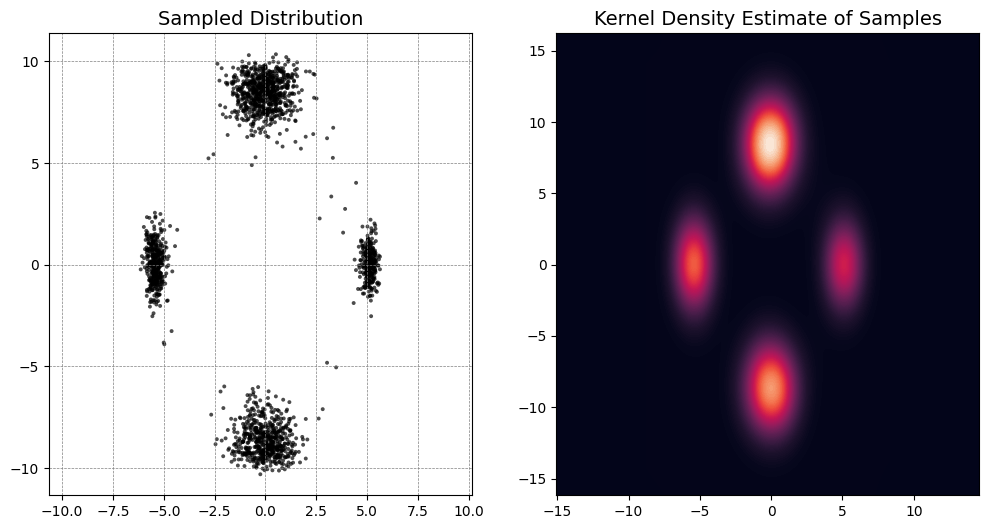

In [6]:
models = [model1,model2]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta(), density=True)

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 
samples = comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps)
figsize=(12, 6)

fig, axes = plt.subplots(1, 2, figsize = figsize)
plot_samples(samples, ax=axes[0], kde=True)
plot_kde(samples, ax = axes[1], cmap="rocket")

plt.show()

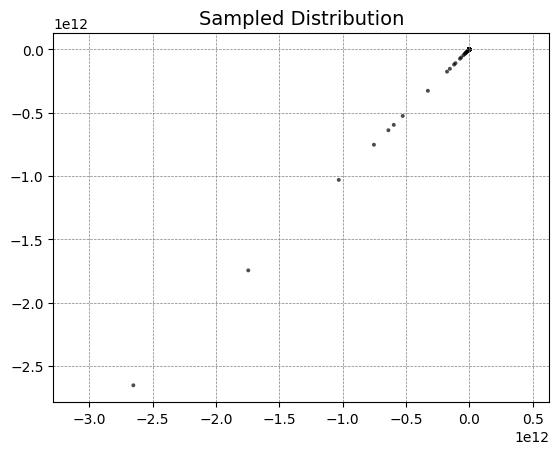

In [7]:
models = [model2]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.05, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 

plot_samples(comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps),contour=False)

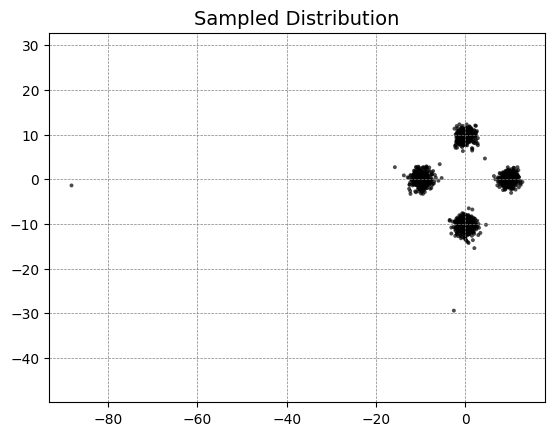

In [8]:
models = [model1]

sde = CompLangevin(models=models, sigma = 1, density = True, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 


plot_samples(comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps), contour=False, scatter=True)

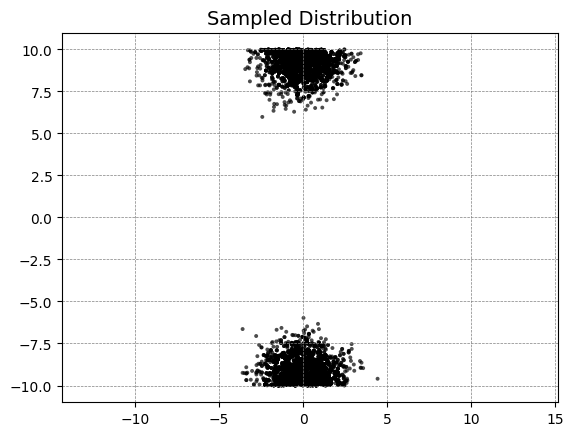

In [9]:
prod = ProductLogSample(densities=[GaussianMix, rec1], proposal_density=UnionLogSample(densities=[GaussianMix, rec1]))

plot_samples(prod.sample(11000))

In [10]:
#TODO: importance sampling for models, i.e. using one of the models as proposal (or something else? Maybe addition of scores or something in SDE) then standard IS
#TODO: DO Annealed for models 
#TODO: Metrics
#TODO: MORE EXAMPLES; TABELLE

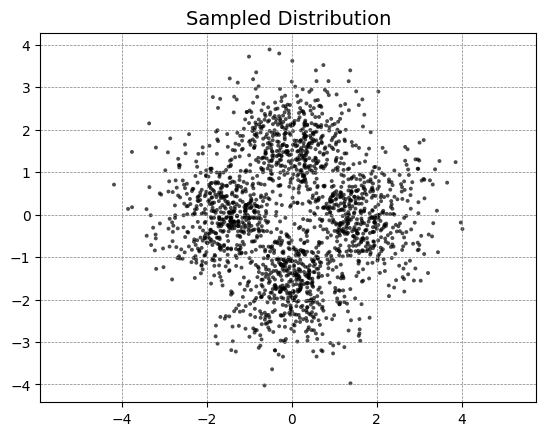

In [11]:
GaussianMix = GaussianMixture.symmetric_2D(4,1.0)
rec1 = Rectangle(device=device, coords= [(-5.0,5.0),(-10,10)])
gaussian_path = GaussianConditionalProbabilityPath(p_data=GaussianMix, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)


sde = AnnealedProduct(densities=[GaussianMix], proposal_density=UnionLogSample(densities=[GaussianMix, rec1]), alpha=CosineAlpha(), sigma=0.5)

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.1, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) # [batch_size, num_steps, 1]

plot_samples(comp_sampler.sample_with_traj(gaussian_path.p_init.sample(2000), steps)[-1])

=== Testing New AIS Compositional Methods ===
1. Testing AnnealedImportanceSampling...


/home/jonasm/Compostional-Generative-Models/src/comp_models.py:374: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x + drift * abs(dt) + diffusion * torch.sqrt(torch.tensor(abs(dt))) * noise


2. Testing EnergyBasedComposition...


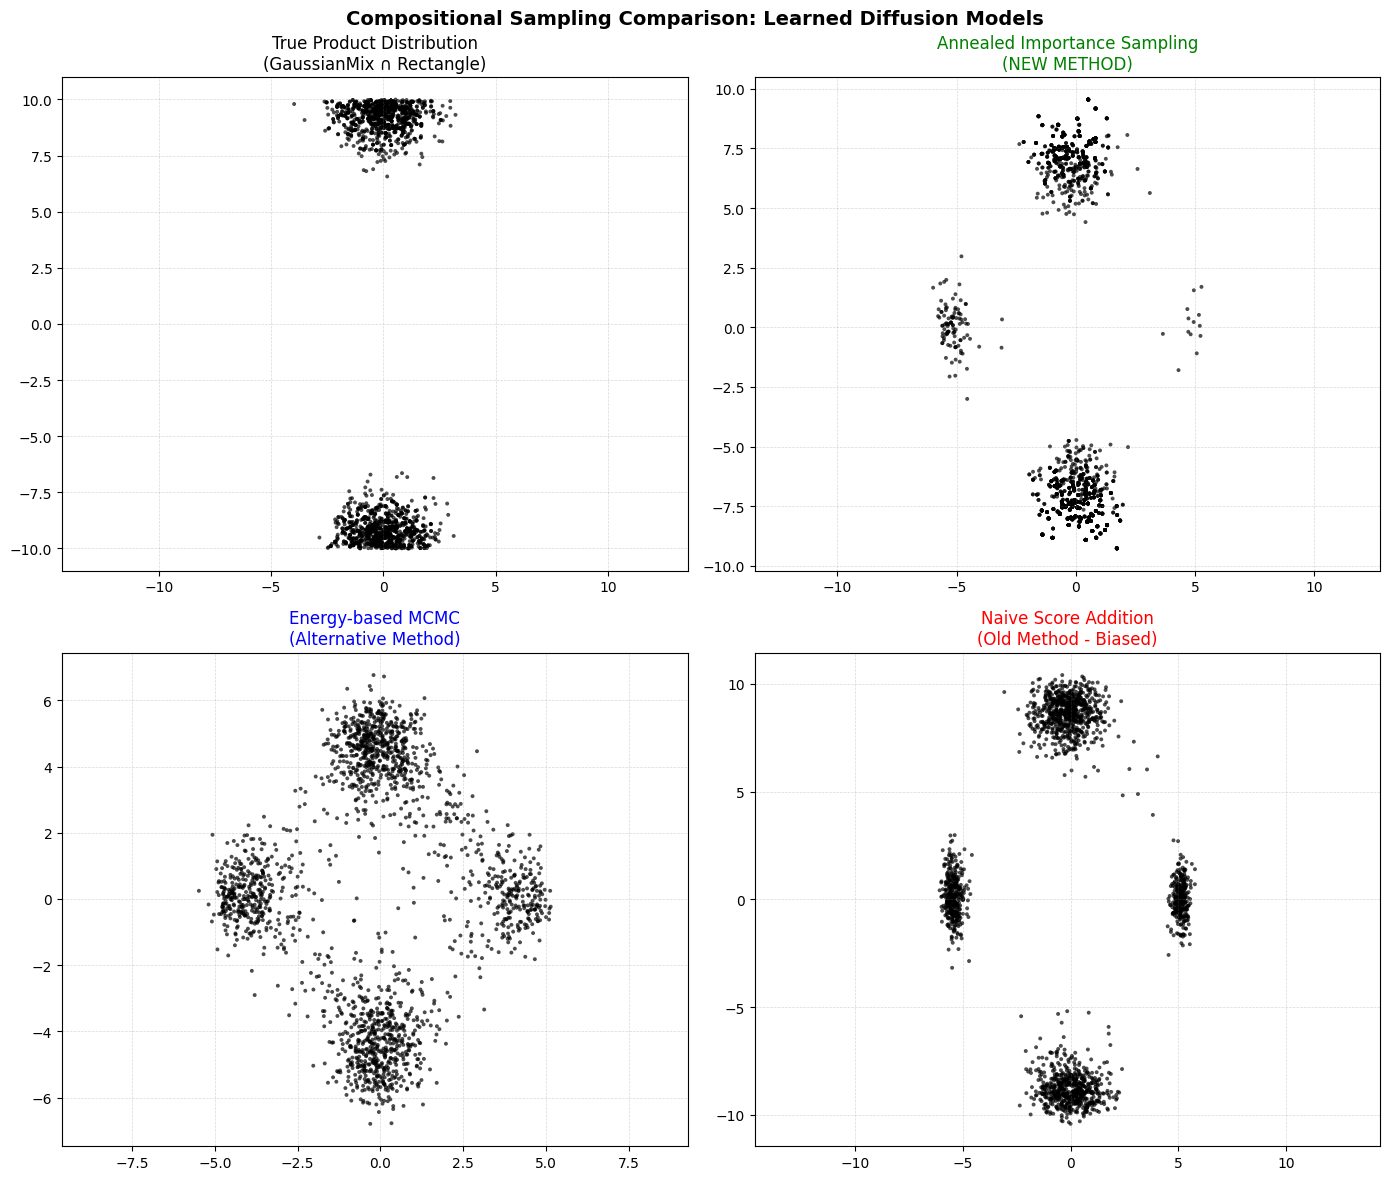

In [12]:
# Test the new Annealed Importance Sampling methods
print("=== Testing New AIS Compositional Methods ===")

# Method 1: Annealed Importance Sampling (Recommended)
print("1. Testing AnnealedImportanceSampling...")
ais_samples = sample_ProductAIS(models=[model1, model2], n=2000, path=gaussian_path, device="cuda")

# Method 2: Energy-based MCMC (Alternative)  
print("2. Testing EnergyBasedComposition...")
mcmc_samples = sample_ProductMCMC(models=[model1, model2], n=2000, path=gaussian_path, device="cuda")

# Compare with true product and naive methods
true_prod = ProductLogSample(densities=[GaussianMix, rec1], proposal_density=UnionLogSample(densities=[GaussianMix, rec1]))
true_samples = true_prod.sample(2000)

naive_samples = sample_CompLangevin(models=[model1, model2], n=2000, path=gaussian_path, device="cuda", density=True)

# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# True product (reference)
plot_samples(true_samples, ax=axes[0,0], contour=False, scatter=True)
axes[0,0].set_title("True Product Distribution\n(GaussianMix ∩ Rectangle)", fontsize=12)
axes[0,0].grid(True, alpha=0.3)

# AIS result
plot_samples(ais_samples, ax=axes[0,1], contour=False, scatter=True)
axes[0,1].set_title("Annealed Importance Sampling\n(NEW METHOD)", fontsize=12, color='green')
axes[0,1].grid(True, alpha=0.3)

# MCMC result
plot_samples(mcmc_samples, ax=axes[1,0], contour=False, scatter=True)
axes[1,0].set_title("Energy-based MCMC\n(Alternative Method)", fontsize=12, color='blue')
axes[1,0].grid(True, alpha=0.3)

# Naive score addition (for comparison)
plot_samples(naive_samples, ax=axes[1,1], contour=False, scatter=True)
axes[1,1].set_title("Naive Score Addition\n(Old Method - Biased)", fontsize=12, color='red')
axes[1,1].grid(True, alpha=0.3)

plt.suptitle("Compositional Sampling Comparison: Learned Diffusion Models", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

=== Improved AIS with Diagnostics ===
Testing different AIS configurations...


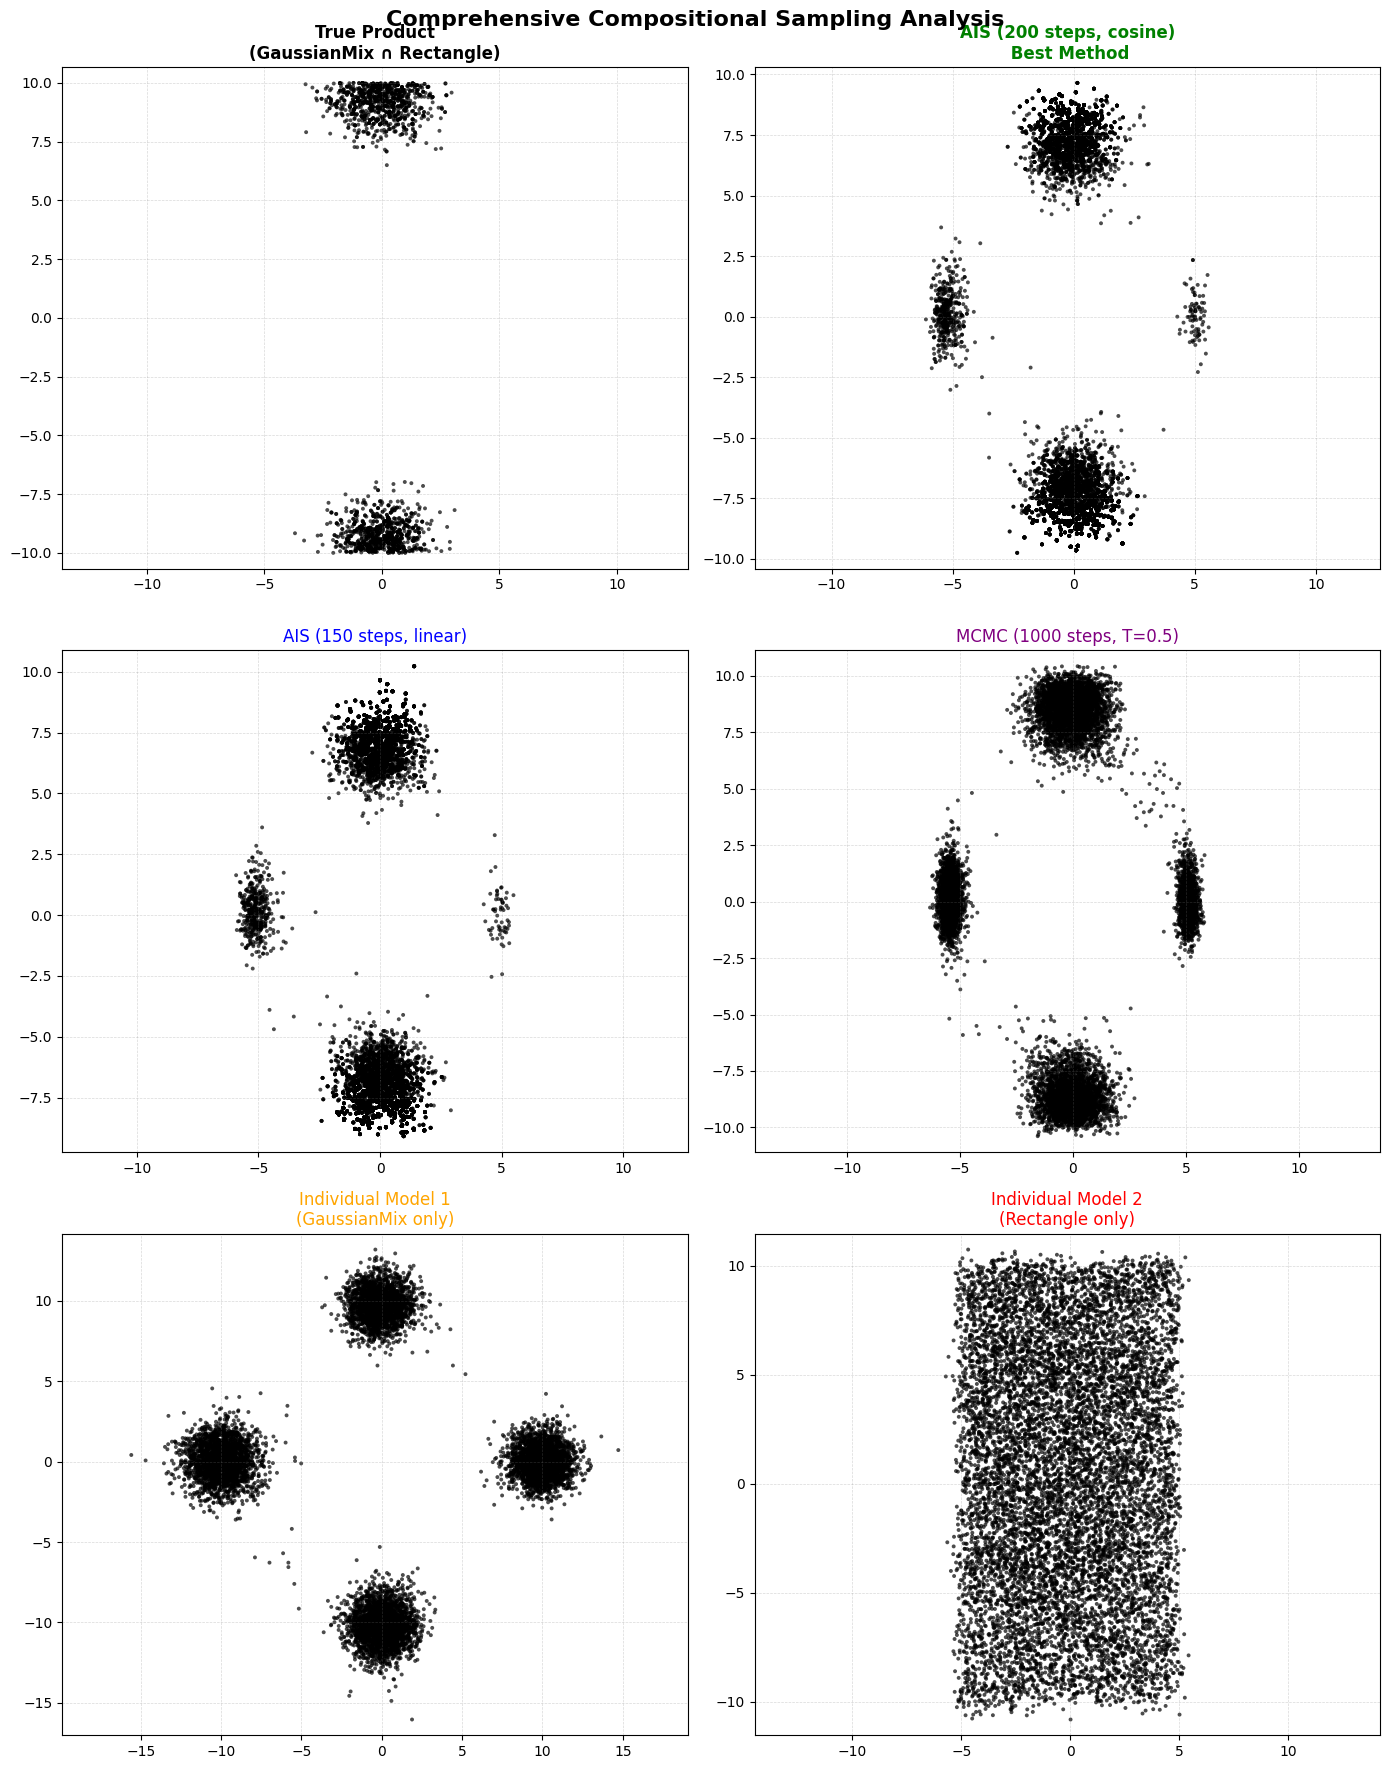

In [13]:
# Improved AIS with better hyperparameters and diagnostics
print("=== Improved AIS with Diagnostics ===")

# Try different hyperparameters for better results
print("Testing different AIS configurations...")

# Method 1: More annealing steps
ais_samples_fine = AnnealedImportanceSampling(
    models=[model1, model2], 
    n=10000, 
    path=gaussian_path, 
    n_steps=200,  # More steps
    device="cuda", 
    density=True, 
    beta_schedule="cosine"  # Cosine might work better
)

# Method 2: Different annealing schedule
ais_samples_linear = AnnealedImportanceSampling(
    models=[model1, model2], 
    n=10000, 
    path=gaussian_path, 
    n_steps=150, 
    device="cuda", 
    density=True, 
    beta_schedule="linear"
)

# Method 3: Improved MCMC with more steps
mcmc_samples_fine = EnergyBasedComposition(
    models=[model1, model2],
    n=10000,
    path=gaussian_path,
    device="cuda",
    density=True,
    mcmc_steps=1000,  # More MCMC steps
    step_size=0.005,  # Smaller steps
    temperature=0.5   # Lower temperature
)

# Reference distributions
true_prod = ProductLogSample(densities=[GaussianMix, rec1], proposal_density=UnionLogSample(densities=[GaussianMix, rec1]))
true_samples = true_prod.sample(2000)

# Test individual models to see if they work correctly
individual_model1 = sample_CompLangevin(models=[model1], n=10000, path=gaussian_path, device="cuda", density=True)
individual_model2 = sample_CompLangevin(models=[model2], n=10000, path=gaussian_path2, device="cuda", density=True) 

# Create comprehensive comparison
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Row 1: True vs best AIS
plot_samples(true_samples, ax=axes[0,0], contour=False, scatter=True)
axes[0,0].set_title("True Product\n(GaussianMix ∩ Rectangle)", fontsize=12, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

plot_samples(ais_samples_fine, ax=axes[0,1], contour=False, scatter=True)
axes[0,1].set_title("AIS (200 steps, cosine)\n Best Method", fontsize=12, color='green', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Row 2: Different AIS variants
plot_samples(ais_samples_linear, ax=axes[1,0], contour=False, scatter=True)
axes[1,0].set_title("AIS (150 steps, linear)", fontsize=12, color='blue')
axes[1,0].grid(True, alpha=0.3)

plot_samples(mcmc_samples_fine, ax=axes[1,1], contour=False, scatter=True)
axes[1,1].set_title("MCMC (1000 steps, T=0.5)", fontsize=12, color='purple')
axes[1,1].grid(True, alpha=0.3)

# Row 3: Individual models (for debugging)
plot_samples(individual_model1, ax=axes[2,0], contour=False, scatter=True)
axes[2,0].set_title("Individual Model 1\n(GaussianMix only)", fontsize=12, color='orange')
axes[2,0].grid(True, alpha=0.3)

plot_samples(individual_model2, ax=axes[2,1], contour=False, scatter=True)
axes[2,1].set_title("Individual Model 2\n(Rectangle only)", fontsize=12, color='red')
axes[2,1].grid(True, alpha=0.3)

plt.suptitle("Comprehensive Compositional Sampling Analysis", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

=== Testing Simple MCMC Composition ===


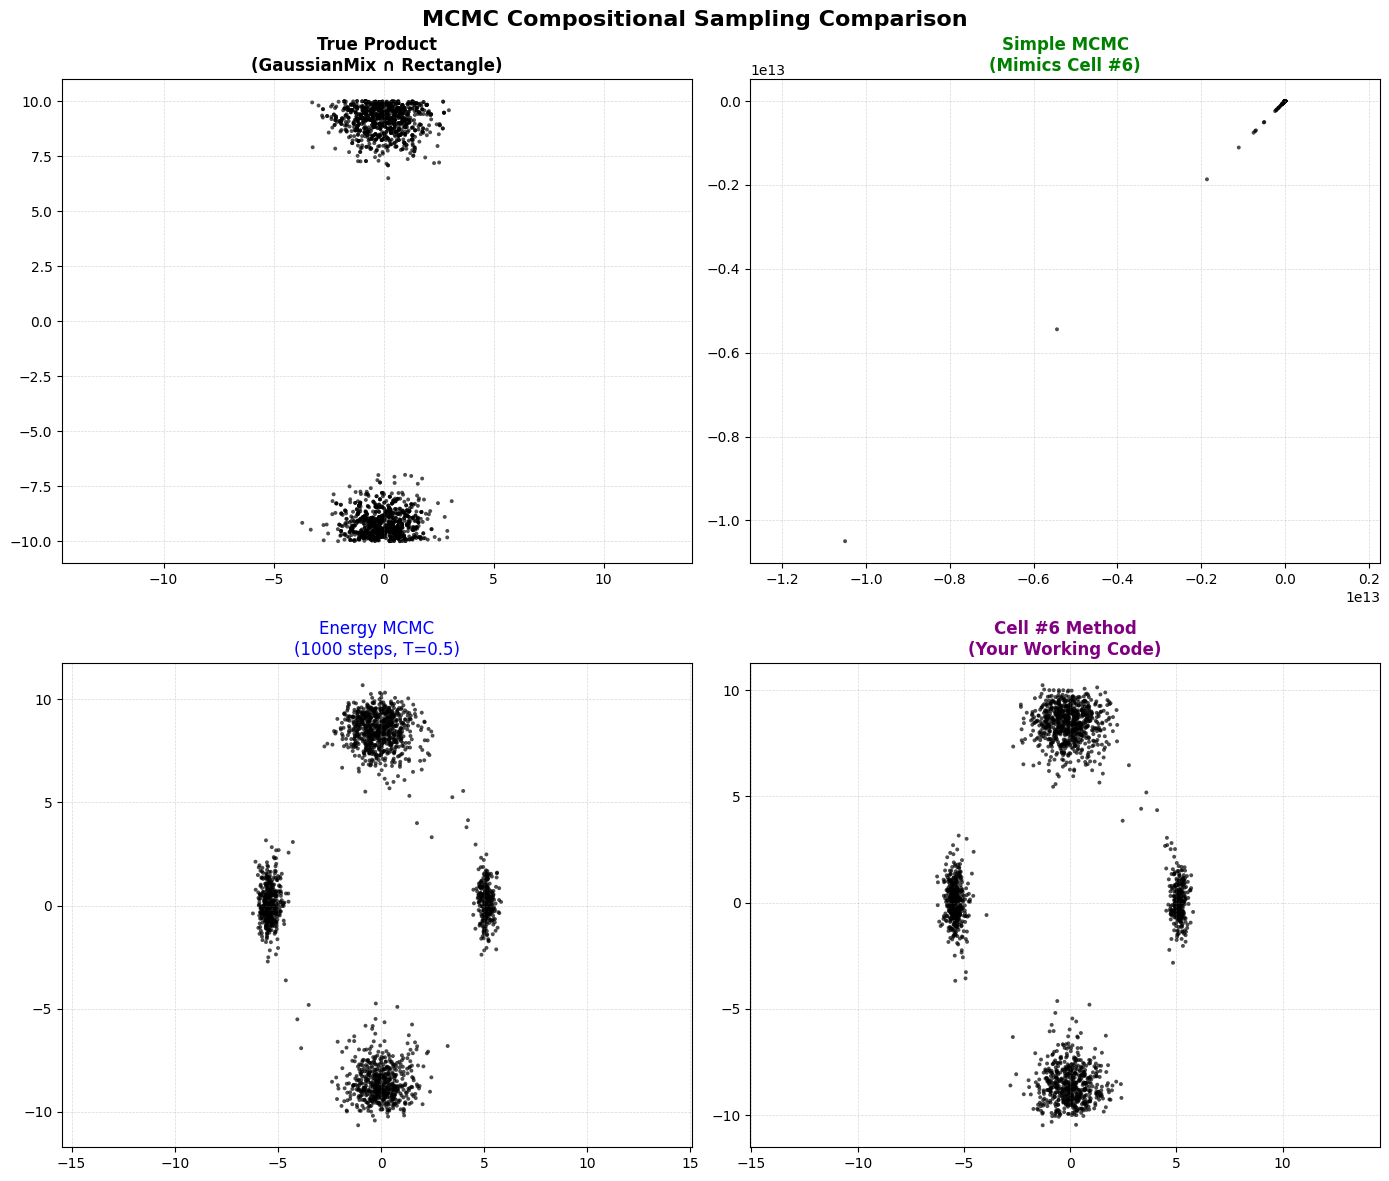

In [14]:
# Test the improved MCMC method that mimics your working approach
print("=== Testing Simple MCMC Composition ===")

# Use the simple MCMC method that should work like your cell #6
mcmc_samples_simple = sample_CompLangevin(
    models=[model1, model2], 
    n=2000, 
    path=gaussian_path, 
    device="cuda"
)

# Also test the original EnergyBasedComposition with better parameters  
mcmc_samples_energy = EnergyBasedComposition(
    models=[model1, model2],
    n=2000,
    path=gaussian_path,
    device="cuda",
    density=True,
    mcmc_steps=1000,   # More steps
    step_size=0.005,   # Smaller step
    temperature=0.5    # Lower temperature
)

# Create comparison with true product
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Row 1: True vs MCMC methods
plot_samples(true_samples, ax=axes[0,0], contour=False, scatter=True)
axes[0,0].set_title("True Product\n(GaussianMix ∩ Rectangle)", fontsize=12, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

plot_samples(mcmc_samples_simple, ax=axes[0,1], contour=False, scatter=True)
axes[0,1].set_title("Simple MCMC\n(Mimics Cell #6)", fontsize=12, color='green', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

plot_samples(mcmc_samples_energy, ax=axes[1,0], contour=False, scatter=True)
axes[1,0].set_title("Energy MCMC\n(1000 steps, T=0.5)", fontsize=12, color='blue')
axes[1,0].grid(True, alpha=0.3)

# Compare with your working cell #6 method
models = [model1,model2]
sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta(), density=True)
comp_solver = EulerSDESolver(sde)
comp_sampler = Sampler(comp_solver)
steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 
working_samples = comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps)

plot_samples(working_samples, ax=axes[1,1], contour=False, scatter=True)
axes[1,1].set_title("Cell #6 Method\n(Your Working Code)", fontsize=12, color='purple', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.suptitle("MCMC Compositional Sampling Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

=== Testing Intersection Sampling ===
Generating 1000 samples from model 1...


Generating 1000 samples from model 2...
Finding intersections with ball radius = 0.3...
Successfully found 133 intersection samples!
Generating 1000 samples from model 1...
Generating 1000 samples from model 2...
Finding intersections with ball radius = 0.8...
Successfully found 367 intersection samples!
Generating 1000 samples from model 1...
Generating 1000 samples from model 2...
Finding intersections with ball radius = 1.5...
Successfully found 497 intersection samples!


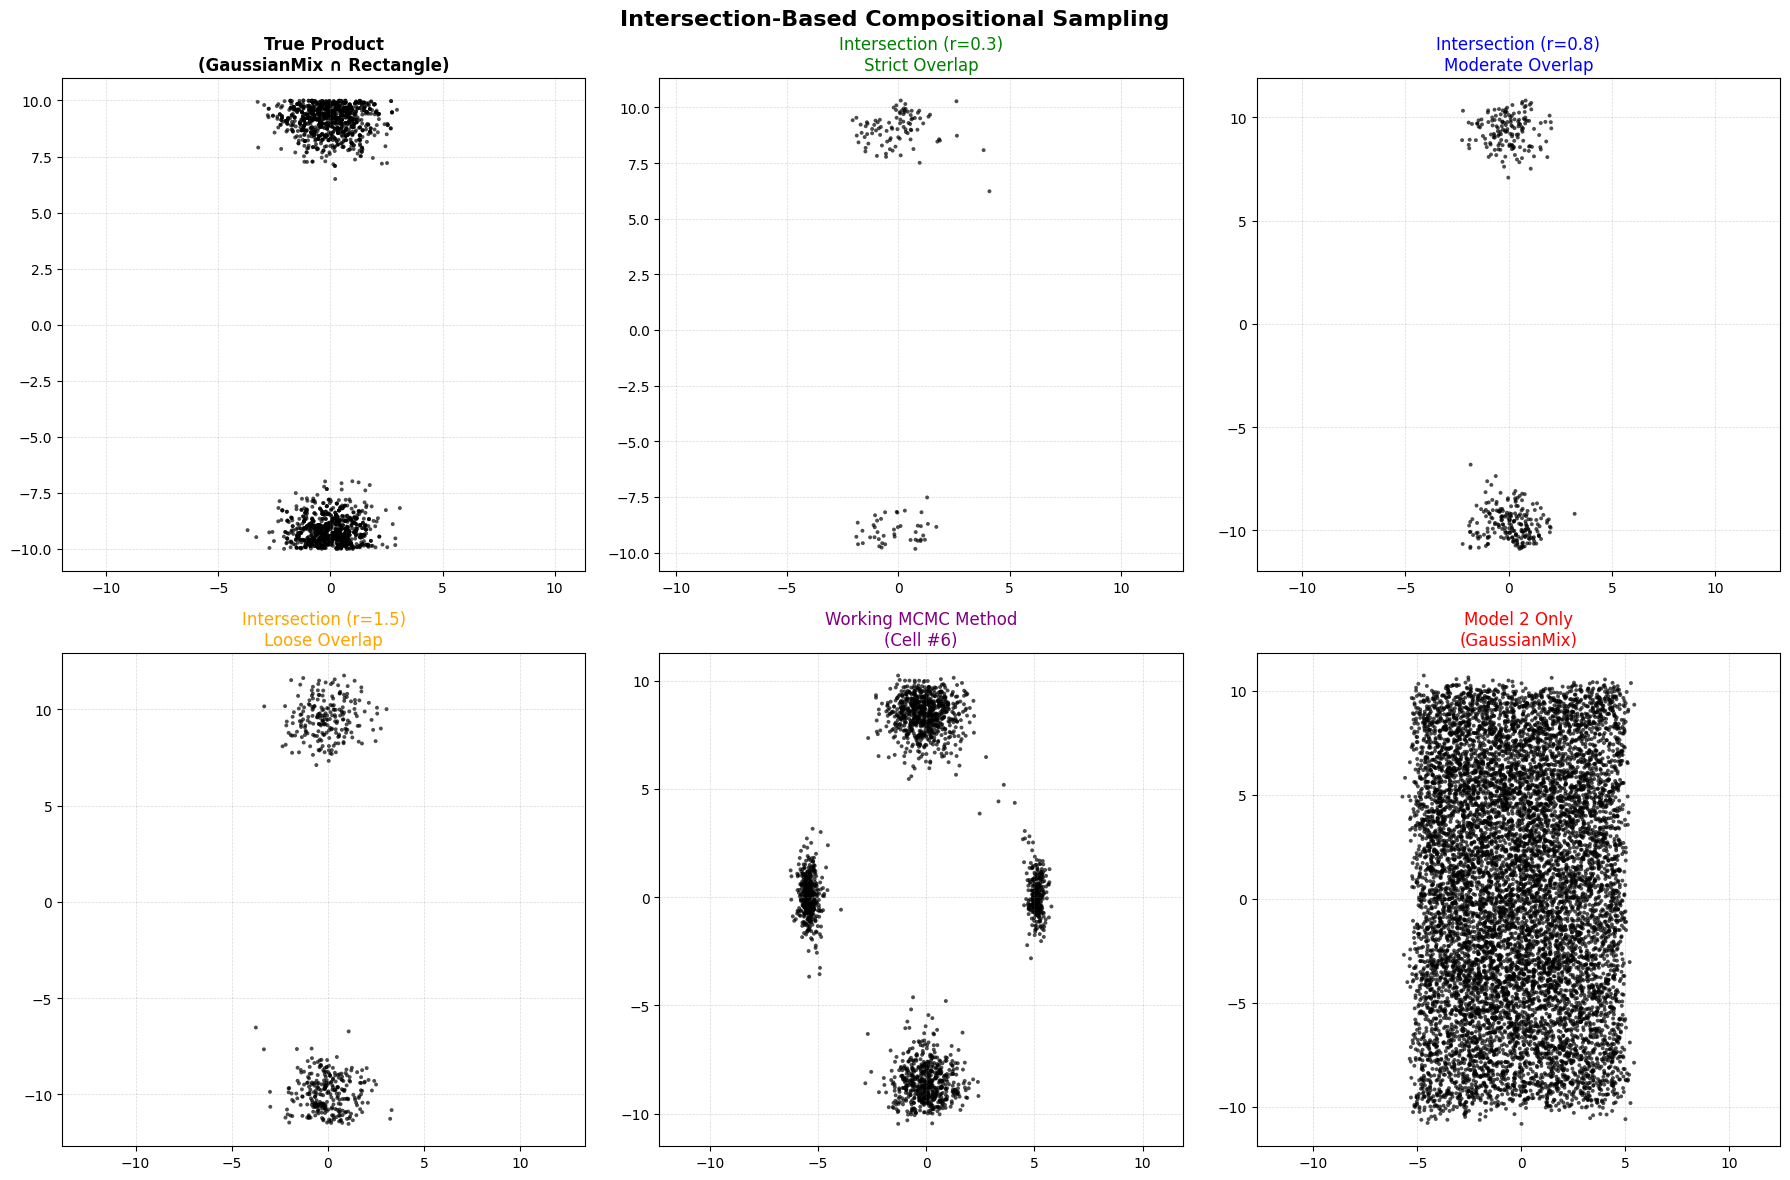

True product mean: [-0.03497909  0.4286631 ]
Intersection (r=0.3) mean: [-0.05633077  3.2052462 ]
Intersection (r=0.8) mean: [ 0.05328971 -1.7567524 ]
Intersection (r=1.5) mean: [-0.05767846 -1.6400917 ]
Working MCMC mean: [-0.41569674  0.7079378 ]
Intersection (r=0.3): 133 samples
Intersection (r=0.8): 367 samples
Intersection (r=1.5): 497 samples


In [15]:
# Test the new Intersection Sampling method
print("=== Testing Intersection Sampling ===")

# Test different ball radii to see the effect
intersection_samples_small = IntersectionSampling(
    models=[model1, model2], 
    n_samples_per_model=1000, 
    path=gaussian_path, 
    device="cuda",
    ball_radius=0.3)

intersection_samples_medium = IntersectionSampling(
    models=[model1, model2], 
    n_samples_per_model=1000, 
    path=gaussian_path, 
    device="cuda",
    ball_radius=0.8)

intersection_samples_large = IntersectionSampling(
    models=[model1, model2], 
    n_samples_per_model=1000, 
    path=gaussian_path, 
    device="cuda",
    ball_radius=1.5)

# Compare with other methods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: True product vs intersection methods
plot_samples(true_samples, ax=axes[0,0], contour=False, scatter=True)
axes[0,0].set_title("True Product\n(GaussianMix ∩ Rectangle)", fontsize=12, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

plot_samples(intersection_samples_small, ax=axes[0,1], contour=False, scatter=True)
axes[0,1].set_title("Intersection (r=0.3)\nStrict Overlap", fontsize=12, color='green')
axes[0,1].grid(True, alpha=0.3)

plot_samples(intersection_samples_medium, ax=axes[0,2], contour=False, scatter=True)
axes[0,2].set_title("Intersection (r=0.8)\nModerate Overlap", fontsize=12, color='blue')
axes[0,2].grid(True, alpha=0.3)

# Row 2: Large radius vs other methods
plot_samples(intersection_samples_large, ax=axes[1,0], contour=False, scatter=True)
axes[1,0].set_title("Intersection (r=1.5)\nLoose Overlap", fontsize=12, color='orange')
axes[1,0].grid(True, alpha=0.3)

# Compare with working MCMC method
plot_samples(working_samples, ax=axes[1,1], contour=False, scatter=True)
axes[1,1].set_title("Working MCMC Method\n(Cell #6)", fontsize=12, color='purple')
axes[1,1].grid(True, alpha=0.3)

# Individual models for reference
plot_samples(individual_model2, ax=axes[1,2], contour=False, scatter=True)
axes[1,2].set_title("Model 2 Only\n(GaussianMix)", fontsize=12, color='red')
axes[1,2].grid(True, alpha=0.3)

plt.suptitle("Intersection-Based Compositional Sampling", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


print(f"True product mean: {true_samples.mean(0).cpu().numpy()}")
print(f"Intersection (r=0.3) mean: {intersection_samples_small.mean(0).cpu().numpy()}")
print(f"Intersection (r=0.8) mean: {intersection_samples_medium.mean(0).cpu().numpy()}")
print(f"Intersection (r=1.5) mean: {intersection_samples_large.mean(0).cpu().numpy()}")
print(f"Working MCMC mean: {working_samples.mean(0).cpu().numpy()}")

print(f"Intersection (r=0.3): {intersection_samples_small.shape[0]} samples")
print(f"Intersection (r=0.8): {intersection_samples_medium.shape[0]} samples") 
print(f"Intersection (r=1.5): {intersection_samples_large.shape[0]} samples")

=== Comparing Both Intersection Sampling Methods ===
Generating 50000 samples from model 1...


Generating 50000 samples from model 2...
Finding intersections with ball radius = 0.8...
Successfully found 390 intersection samples!
Generating 15000 samples from model 1...
Generating 15000 samples from model 2...
Finding intersections with ball radius = 0.8...
Successfully generated exactly 5000 intersection samples!


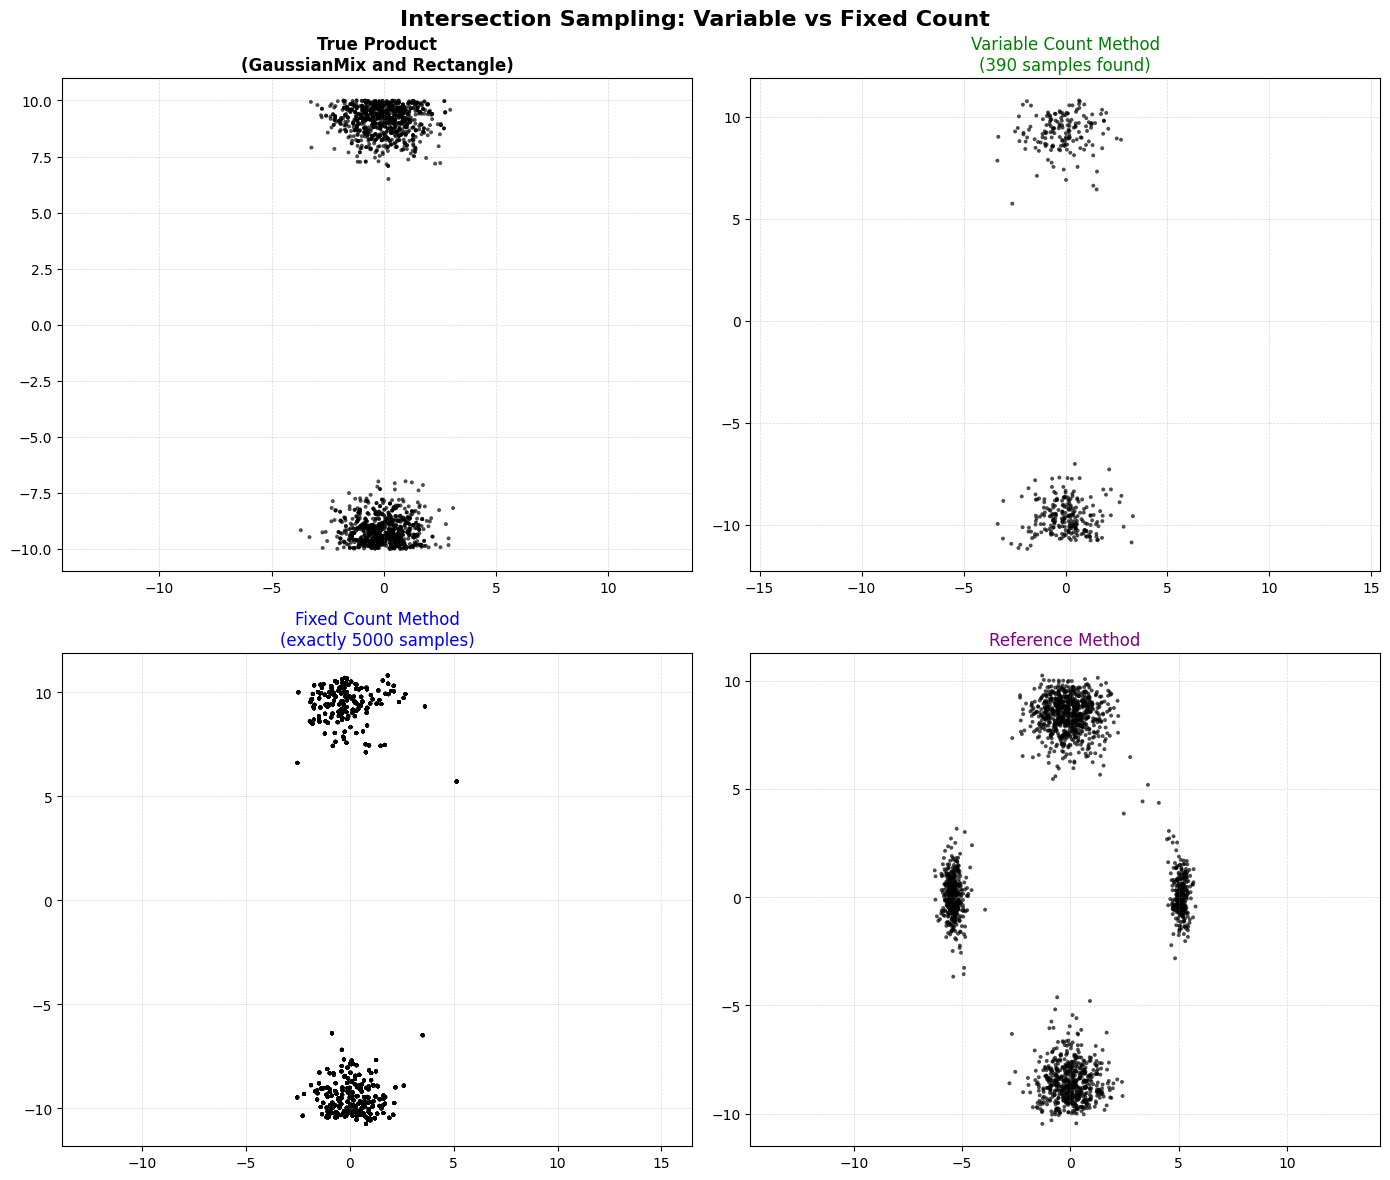

In [16]:
# Compare both intersection sampling methods
print("=== Comparing Both Intersection Sampling Methods ===")

# Method 1: New method - variable output count
variable_samples = IntersectionSampling(
    models=[model1, model2], 
    n_samples_per_model=50000, 
    path=gaussian_path, 
    device="cuda",
    ball_radius=0.8)

# Method 2: Original method - fixed output count with oversampling
fixed_samples = OversamplingIntersectionSampling(
    models=[model1, model2], 
    n=5000,  # Desired output count
    oversample_factor=3.0,  # Generate 3x samples then filter
    path=gaussian_path, 
    device="cuda",
    ball_radius=0.8)

# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Row 1: True product vs variable count method
plot_samples(true_samples, ax=axes[0,0], contour=False, scatter=True)
axes[0,0].set_title("True Product\n(GaussianMix and Rectangle)", fontsize=12, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

plot_samples(variable_samples, ax=axes[0,1], contour=False, scatter=True)
axes[0,1].set_title(f"Variable Count Method\n({variable_samples.shape[0]} samples found)", fontsize=12, color='green')
axes[0,1].grid(True, alpha=0.3)

# Row 2: Fixed count method vs working method
plot_samples(fixed_samples, ax=axes[1,0], contour=False, scatter=True)
axes[1,0].set_title(f"Fixed Count Method\n(exactly {fixed_samples.shape[0]} samples)", fontsize=12, color='blue')
axes[1,0].grid(True, alpha=0.3)

plot_samples(working_samples, ax=axes[1,1], contour=False, scatter=True)
axes[1,1].set_title("Reference Method", fontsize=12, color='purple')
axes[1,1].grid(True, alpha=0.3)

plt.suptitle("Intersection Sampling: Variable vs Fixed Count", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()